<a href="https://colab.research.google.com/github/ashucreative/PySpark_Notes/blob/main/Learning_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
###  LINK TO YOUR FILE HERE
link =  "https://drive.google.com/file/d/1aAaX3cAlV-a5QAVluqTS2oA2A3ezyXKL/view?usp=sharing"

#### Installation and Set up

In [2]:
## Install PySpark and Create a Spark Session
## pip install pyspark
!pip install -q pyspark

## Creating Spark Session
from pyspark.sql import SparkSession
spark= SparkSession.builder.appName("test-app").getOrCreate()

### Chapter 1 : Get Familiar with Spark
#### Set up Spark , Read the file into Spark Dataframe, and run basic commands like show(), printSchema() and etc.

In [3]:
import requests
import pandas as pd
import re
import io

## extract file id from the link

file_id = re.search(r"(?<=/d/)[^/]+", link).group(0)

## create download url for requests
url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:

    ## In Spark we cannnot use in memory file object with StrinIO so need to create a temp file first
    # Write the content to a temporary file
    temp_file_path = "temp_file.csv"
    with open(temp_file_path, 'w', encoding='utf-8') as temp_file:
        temp_file.write(response.text)

    # Load the data into spark DF using temp file path
    data = spark.read.csv(temp_file_path , header = True, inferSchema = True)
    print("Successfully Created Spark Dataframe named as data")
else:
    print(f"Failed to download file. Status code: {response.status_code}")


Successfully Created Spark Dataframe named as data


In [4]:
## In Spark, just like pandas df head command, we have show command
data.show()


+----------+-------------+------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+--------------------+------------+-------------+----------------+---------+----------------+--------------------------+--------------------------+----------------------------+----------------------------+-----------------------------+----------------------------+----------------------------+-----------------------------+
|      date|    home_team|   away_team|home_team_continent|away_team_continent|home_team_fifa_rank|away_team_fifa_rank|home_team_total_fifa_points|away_team_total_fifa_points|home_team_score|away_team_score|          tournament|        city|      country|neutral_location|shoot_out|home_team_result|home_team_goalkeeper_score|away_team_goalkeeper_score|home_team_mean_defense_score|home_team_mean_offense_score|home_team_mean_midfield_score|away_team_mean_defense_score|

In [5]:
## You can view the schema of the data
## IF you look the code we used to read data, I used inferSchema = True , which automatically infers schema and read the right data type from the file. By default inferSchema is False, and if we do not set it True, it will read everything as String objects.
data.printSchema()

root
 |-- date: date (nullable = true)
 |-- home_team: string (nullable = true)
 |-- away_team: string (nullable = true)
 |-- home_team_continent: string (nullable = true)
 |-- away_team_continent: string (nullable = true)
 |-- home_team_fifa_rank: integer (nullable = true)
 |-- away_team_fifa_rank: integer (nullable = true)
 |-- home_team_total_fifa_points: integer (nullable = true)
 |-- away_team_total_fifa_points: integer (nullable = true)
 |-- home_team_score: integer (nullable = true)
 |-- away_team_score: integer (nullable = true)
 |-- tournament: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- neutral_location: boolean (nullable = true)
 |-- shoot_out: string (nullable = true)
 |-- home_team_result: string (nullable = true)
 |-- home_team_goalkeeper_score: double (nullable = true)
 |-- away_team_goalkeeper_score: double (nullable = true)
 |-- home_team_mean_defense_score: double (nullable = true)
 |-- home_team_mean_offens

In [6]:
## Now lets try to create a simple data by passing the data as a list of tuples, similar way we do in Pandas
# Create DataFrame
sample_data = [('James','','Smith','1991-04-01','M',3000),
  ('Michael','Rose','','2000-05-19','M',4000),
  ('Robert','','Williams','1978-09-05','M',4000),
  ('Maria','Anne','Jones','1967-12-01','F',4000),
  ('Jen','Mary','Brown','1980-02-17','F',-1)
]

columns = ["firstname","middlename","lastname","dob","gender","salary"]
df = spark.createDataFrame(data= sample_data, schema = columns)
df.show()

+---------+----------+--------+----------+------+------+
|firstname|middlename|lastname|       dob|gender|salary|
+---------+----------+--------+----------+------+------+
|    James|          |   Smith|1991-04-01|     M|  3000|
|  Michael|      Rose|        |2000-05-19|     M|  4000|
|   Robert|          |Williams|1978-09-05|     M|  4000|
|    Maria|      Anne|   Jones|1967-12-01|     F|  4000|
|      Jen|      Mary|   Brown|1980-02-17|     F|    -1|
+---------+----------+--------+----------+------+------+



### Chapter 2: Data Cleaning
##### 2.1 Finding and taking care of missing values , creating a new Column

In [7]:
## Find missing values per column
import pyspark.sql.functions as F

def countNullValues(df):
    """
    This function counts the null values in a pyspark dataframe and returns pandas df as result
    :param df: A PySpark DataFrame
    """
    df_return = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T
    df_return.columns = ['Null_Value_Count']
    df_return['Percentage_Missing'] = df_return['Null_Value_Count']/df.count()
    df_return.sort_values(by='Null_Value_Count', ascending = False, inplace=True)
    return df_return

countNullValues(data)

,Null_Value_Count,Percentage_Missing
away_team_mean_defense_score,16357,0.683792
home_team_mean_defense_score,16134,0.674470
away_team_mean_midfield_score,15942,0.666444
away_team_goalkeeper_score,15826,0.661594
home_team_mean_midfield_score,15759,0.658794
away_team_mean_offense_score,15609,0.652523
home_team_goalkeeper_score,15542,0.649722
home_team_mean_offense_score,15411,0.644246
date,0,0.000000
away_team_total_fifa_points,0,0.000000


#### As we can see that most missing columns have more than 50% of data missing.
#### As a rule of thumb when you have that many data missing, imputing can be challenging so simple solution is to drop them with caution. The caution here means understand the data. In our example: these are some of the additional scores, not the main scores of game lose or win.
#### We will set up a threshold rule to drop those columns, we will look into imputing examples later.

In [ ]:

import math
def dropNullColumns(df):
    """
    This function drops columns containing 50 % or more null values
    :param df: A PySpark DataFrame
    """
    threshold = math.floor(df.count()/2) ## 50 percent thresholding- can be adjusted as needed
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(
        c) for c in df.columns]).collect()[0].asDict()
    col_to_drop = [k for k, v in null_counts.items() if v > threshold]
    df = df.drop(*col_to_drop)

    return df

data=dropNullColumns(data)
data.show(5)

+----------+---------+------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+--------------------+--------+--------+----------------+---------+----------------+
|      date|home_team|   away_team|home_team_continent|away_team_continent|home_team_fifa_rank|away_team_fifa_rank|home_team_total_fifa_points|away_team_total_fifa_points|home_team_score|away_team_score|          tournament|    city| country|neutral_location|shoot_out|home_team_result|
+----------+---------+------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+--------------------+--------+--------+----------------+---------+----------------+
|1993-08-08|  Bolivia|     Uruguay|      South America|      South America|                 59|                 22|                        

In [ ]:
## Now if we re- run the count Null Values, we should see it cleaner
countNullValues(data)

,Null_Value_Count,Percentage_Missing
date,0,0.0
home_team_score,0,0.0
shoot_out,0,0.0
neutral_location,0,0.0
country,0,0.0
city,0,0.0
tournament,0,0.0
away_team_score,0,0.0
away_team_total_fifa_points,0,0.0
home_team,0,0.0


#### 2.2 Finding Unique Values in a given Column


In [ ]:
# We simply use the interested column and run a distinct function. Notice something that it will not give us the output yet.
data.select('home_team_result').distinct()

DataFrame[home_team_result: string]

##### Why we did not get output above ? Because Spark is a lazy execution , meaning until we pass the commands like collect, show, etc. It will only build the execution plan in memory but it will not run it actually.

In [ ]:
## Once we chain the collect () function we shall see the output, that win, draw and lose are three unique values
data.select('home_team_result').distinct().collect()

[Row(home_team_result='Win'),
 Row(home_team_result='Draw'),
 Row(home_team_result='Lose')]

#### 2.3 Label Encoding: If you want to create derived features out of existing features, or in this example we are creating the numerical encoding for labels if we want to use this field as our prediction column.

In [ ]:
## Add a new column to encode or create derived features
## Lets say our target label is home_team_result column, and we want to encode lose, draw, win as 0, 1, 2
mapping = {'Lose': 0, 'Draw': 1, 'Win': 2}
map_col = F.create_map([F.lit(x) for i in mapping.items() for x in i])
data = data.withColumn('Result_Class', map_col[F.col('home_team_result')])
data.show(5)

+----------+---------+------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+--------------------+--------+--------+----------------+---------+----------------+------------+
|      date|home_team|   away_team|home_team_continent|away_team_continent|home_team_fifa_rank|away_team_fifa_rank|home_team_total_fifa_points|away_team_total_fifa_points|home_team_score|away_team_score|          tournament|    city| country|neutral_location|shoot_out|home_team_result|Result_Class|
+----------+---------+------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+--------------------+--------+--------+----------------+---------+----------------+------------+
|1993-08-08|  Bolivia|     Uruguay|      South America|      South America|                 59|     

#### Chapter 3: Exploratory Data Analysis (EDA)

3.1 Using Group By

In [ ]:
## Lets use Group By to do some aggregation
## Below example shows we want to see the distribution of WIN, DRAW and LOSE
data.groupBy('home_team_result').count().show()

+----------------+-----+
|home_team_result|count|
+----------------+-----+
|             Win|11761|
|            Draw| 5389|
|            Lose| 6771|
+----------------+-----+



##### 3.2 Using SQL
Are you more comfortable in SQL than pandas ? Then PySpark got your back. Lets try to run pure SQL in Spark.

In [ ]:
# Above result in spark SQL
## First we need to create a temp table for our dataframe
data.createOrReplaceTempView("data_table")

## Now we can run our select query

query = f"""
         SELECT home_team_result, COUNT(*) as count
         FROM data_table
         GROUP BY home_team_result
         """
## simply pass the query to spark.sql and remember Spark is lazy execution so we must show it.

spark.sql(query).show()


+----------------+-----+
|home_team_result|count|
+----------------+-----+
|             Win|11761|
|            Draw| 5389|
|            Lose| 6771|
+----------------+-----+



In [ ]:
## While it makes sense to view the overall distribution of results, but it is more useful to have by country.
## we just need a list of columns we want to group by, and we can also apply sorting by country name
data.groupBy(['home_team','home_team_result']).count().sort('home_team').show()

+--------------+----------------+-----+
|     home_team|home_team_result|count|
+--------------+----------------+-----+
|   Afghanistan|            Lose|   12|
|   Afghanistan|            Draw|    8|
|   Afghanistan|             Win|   16|
|       Albania|            Draw|   30|
|       Albania|             Win|   52|
|       Albania|            Lose|   49|
|       Algeria|            Draw|   30|
|       Algeria|             Win|   91|
|       Algeria|            Lose|   38|
|American Samoa|             Win|    3|
|American Samoa|            Lose|   13|
|American Samoa|            Draw|    1|
|       Andorra|             Win|   10|
|       Andorra|            Draw|   13|
|       Andorra|            Lose|   74|
|        Angola|            Draw|   45|
|        Angola|             Win|   74|
|        Angola|            Lose|   26|
|      Anguilla|            Lose|   10|
|      Anguilla|             Win|    1|
+--------------+----------------+-----+
only showing top 20 rows



In [ ]:
# we can run above code in spark sql, once we create temp table we can use it

query = f"""
         SELECT home_team, home_team_result, COUNT(*) as count
         FROM data_table
         GROUP BY home_team, home_team_result
         ORDER BY home_team
         """
spark.sql(query).show()


+--------------+----------------+-----+
|     home_team|home_team_result|count|
+--------------+----------------+-----+
|   Afghanistan|            Lose|   12|
|   Afghanistan|            Draw|    8|
|   Afghanistan|             Win|   16|
|       Albania|            Draw|   30|
|       Albania|             Win|   52|
|       Albania|            Lose|   49|
|       Algeria|            Draw|   30|
|       Algeria|             Win|   91|
|       Algeria|            Lose|   38|
|American Samoa|             Win|    3|
|American Samoa|            Lose|   13|
|American Samoa|            Draw|    1|
|       Andorra|             Win|   10|
|       Andorra|            Draw|   13|
|       Andorra|            Lose|   74|
|        Angola|            Draw|   45|
|        Angola|             Win|   74|
|        Angola|            Lose|   26|
|      Anguilla|            Lose|   10|
|      Anguilla|             Win|    1|
+--------------+----------------+-----+
only showing top 20 rows



In [ ]:
## Now lets analyze results for Brazil
## first we filter home team for Brazil, then group by result and do count
data.where(F.col('home_team') == 'Brazil').groupBy(['home_team','home_team_result']).count().show()

+---------+----------------+-----+
|home_team|home_team_result|count|
+---------+----------------+-----+
|   Brazil|             Win|  181|
|   Brazil|            Draw|   31|
|   Brazil|            Lose|   21|
+---------+----------------+-----+



In [ ]:
## we can also run the above code using spark sql
## all we need is to create a temp table from our dataframe
data.createOrReplaceTempView("data_table")

query = f"""
         SELECT home_team, home_team_result, COUNT(*) as count
         FROM data_table
         WHERE home_team = 'Brazil'
         GROUP BY 1,2
         """
spark.sql(query).show()

+---------+----------------+-----+
|home_team|home_team_result|count|
+---------+----------------+-----+
|   Brazil|             Win|  181|
|   Brazil|            Draw|   31|
|   Brazil|            Lose|   21|
+---------+----------------+-----+



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

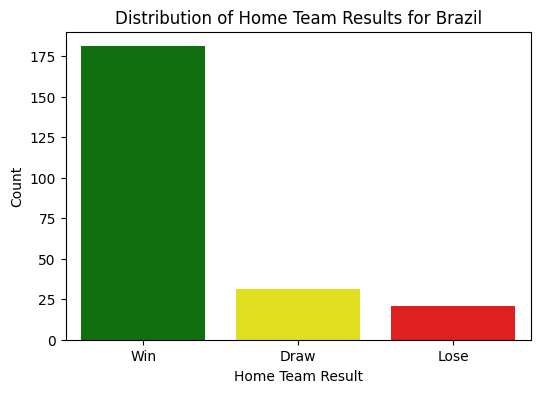

In [ ]:
## We want a bar plot for above result
## first capture that result in a temp df and plot it
temp_df = spark.sql(query).toPandas()

plt.figure(figsize=(6, 4))
sns.barplot(x='home_team_result', y='count', data=temp_df, hue= 'home_team_result',
            palette = {'Win': 'green', 'Draw': 'yellow', 'Lose': 'red'}, legend = False)
plt.title('Distribution of Home Team Results for Brazil')
plt.xlabel('Home Team Result')
plt.ylabel('Count')
plt.show()

In [ ]:
# We want to get the top 10 countries with the most wins

top_10_wins = data.groupBy('home_team') \
                  .agg(F.sum(F.when(F.col('home_team_result') == 'Win', 1).otherwise(0)) \
                  .alias('total_wins')).orderBy(F.col('total_wins').desc()).limit(10)
top_10_wins.show()


+--------------+----------+
|     home_team|total_wins|
+--------------+----------+
|           USA|       194|
|        Mexico|       190|
|        Brazil|       181|
|  Saudi Arabia|       164|
|         Egypt|       163|
|         Japan|       154|
|         Spain|       145|
|        France|       145|
|Korea Republic|       140|
|       Germany|       139|
+--------------+----------+



In [ ]:
# we can also run the above result using spark SQL

query = f"""
         SELECT home_team, SUM(CASE WHEN home_team_result = 'Win' THEN 1 ELSE 0 END) as total_wins
         FROM data_table
         GROUP BY home_team
         ORDER BY total_wins DESC
         LIMIT 10
         """
spark.sql(query).show()


+--------------+----------+
|     home_team|total_wins|
+--------------+----------+
|           USA|       194|
|        Mexico|       190|
|        Brazil|       181|
|  Saudi Arabia|       164|
|         Egypt|       163|
|         Japan|       154|
|         Spain|       145|
|        France|       145|
|Korea Republic|       140|
|       Germany|       139|
+--------------+----------+



In [ ]:
## Lets see the describe function, which gives us the descriptive stats for all numerical columns in dataframe
description = data.describe().toPandas().dropna(axis=1).T
description

,0,1,2,3,4
summary,count,mean,stddev,min,max
home_team_fifa_rank,23921,77.85468834914928,52.35522517098862,1,211
away_team_fifa_rank,23921,80.79737469169349,53.2329018803766,1,211
home_team_total_fifa_points,23921,323.40148823209734,500.82572453797627,0,2164
away_team_total_fifa_points,23921,315.4535763555035,490.94427310371316,0,2164
home_team_score,23921,1.6092136616362192,1.63012671231451,0,31
away_team_score,23921,1.0682663768237113,1.263944312867616,0,21
Result_Class,23921,1.2086033192592283,0.8551210439874892,0,2


In [ ]:
## Looking at above , I am really intterested to find that game where score was 31

query = """
   SELECT date, home_team, away_team, home_team_score, away_team_score, tournament
   FROM data_table
   WHERE home_team_score = 31
"""
spark.sql(query).show()


+----------+---------+--------------+---------------+---------------+--------------------+
|      date|home_team|     away_team|home_team_score|away_team_score|          tournament|
+----------+---------+--------------+---------------+---------------+--------------------+
|2001-04-11|Australia|American Samoa|             31|              0|FIFA World Cup qu...|
+----------+---------+--------------+---------------+---------------+--------------------+



### Chapter 4: More on Exploratory Data Analysis :EDA

In [ ]:
## Question: How many unique teams are here on our data ?
data.select('home_team').distinct().count()

211

In [ ]:
## If every team had played home and away games, the away team cound should be same , lets check
data.select('away_team').distinct().count()

211

In [ ]:
## lets get the above results in SQL
query = f"""
         SELECT COUNT(DISTINCT home_team) as home_team_count, COUNT(DISTINCT away_team) as away_team_count
         FROM data_table
         """
spark.sql(query).show()

+---------------+---------------+
|home_team_count|away_team_count|
+---------------+---------------+
|            211|            211|
+---------------+---------------+



In [ ]:
## Earlier we saw USA has the highest number of wins, but that does not necessarily mean USA will rank first, lets see top 5 ranked teams
## Basically we just filter for that rank column

data.filter(data['home_team_fifa_rank'] == 1).select('home_team').show()

+---------+
|home_team|
+---------+
|  Germany|
|   Brazil|
|  Germany|
|  Germany|
|  Germany|
|  Germany|
|   Brazil|
|   Brazil|
|   Brazil|
|   Brazil|
|   Brazil|
|   Brazil|
|   Brazil|
|   Brazil|
|   Brazil|
|   Brazil|
|   Brazil|
|   Brazil|
|   Brazil|
|   Brazil|
+---------+
only showing top 20 rows



###### What happened above ? I was thinking I will get the number 1 ranked company, expecting one data point as result. But it makes sense in our data that 'rank' actually changes over time, and we have timestamp. Now, how to get the best team so far , meaning the team that was ranked 1 highest number of times.


In [ ]:
# We want to sum home_team_fifa_rank and then display lowest SUM, would be our number 1 overall team

data.groupBy('home_team') \
    .agg(F.sum('home_team_fifa_rank').alias('total_rank')) \
    .orderBy(F.col('total_rank')) \
    .show(1)


+---------+----------+
|home_team|total_rank|
+---------+----------+
|   Brazil|       806|
+---------+----------+
only showing top 1 row



In [ ]:
## I can simply change the number if I want top 10
data.groupBy('home_team') \
    .agg(F.sum('home_team_fifa_rank').alias('total_rank')) \
    .orderBy(F.col('total_rank')) \
    .show(10)

+--------------------+----------+
|           home_team|total_rank|
+--------------------+----------+
|              Brazil|       806|
|               Spain|      1014|
|           Argentina|      1291|
|             Germany|      1523|
|Turks and Caicos ...|      1601|
|               Italy|      1792|
|              France|      1795|
|        Cook Islands|      1906|
|            Portugal|      1906|
|         Netherlands|      1950|
+--------------------+----------+
only showing top 10 rows



In [ ]:
## Generate above result in SQL
query = f"""
         SELECT home_team, SUM(home_team_fifa_rank) as total_rank
         FROM data_table
         GROUP BY home_team
         ORDER BY total_rank
         LIMIT 10
         """
spark.sql(query).show()

+--------------------+----------+
|           home_team|total_rank|
+--------------------+----------+
|              Brazil|       806|
|               Spain|      1014|
|           Argentina|      1291|
|             Germany|      1523|
|Turks and Caicos ...|      1601|
|               Italy|      1792|
|              France|      1795|
|        Cook Islands|      1906|
|            Portugal|      1906|
|         Netherlands|      1950|
+--------------------+----------+



In [ ]:
## I am noticing something here, Turks and Caicos ranked higher than Italy and France ??? That makes no sense
## What we did was overall ranking for team, but ranking depends on the continent, so lets add one more group by home_team_continent
## And we can filter for example South America , which will make more sense: Remember lower the better for rank
data.groupBy(['home_team','home_team_continent']) \
    .agg(F.sum('home_team_fifa_rank').alias('total_rank')) \
    .orderBy(F.col('total_rank')) \
    .filter(F.col('home_team_continent') == 'South America') \
    .show(10)

+---------+-------------------+----------+
|home_team|home_team_continent|total_rank|
+---------+-------------------+----------+
|   Brazil|      South America|       806|
|Argentina|      South America|      1291|
|  Uruguay|      South America|      3269|
| Colombia|      South America|      3369|
| Paraguay|      South America|      4201|
|    Chile|      South America|      4727|
|  Ecuador|      South America|      6090|
| Suriname|      South America|      6505|
|     Peru|      South America|      6817|
|   Guyana|      South America|      7241|
+---------+-------------------+----------+
only showing top 10 rows



In [ ]:
# We can get above results in SQL

query = f"""
         SELECT home_team, home_team_continent, SUM(home_team_fifa_rank) as total_rank
         FROM data_table
         WHERE home_team_continent = 'South America'
         GROUP BY home_team, home_team_continent
         ORDER BY total_rank
         LIMIT 10
         """
spark.sql(query).show()


+---------+-------------------+----------+
|home_team|home_team_continent|total_rank|
+---------+-------------------+----------+
|   Brazil|      South America|       806|
|Argentina|      South America|      1291|
|  Uruguay|      South America|      3269|
| Colombia|      South America|      3369|
| Paraguay|      South America|      4201|
|    Chile|      South America|      4727|
|  Ecuador|      South America|      6090|
| Suriname|      South America|      6505|
|     Peru|      South America|      6817|
|   Guyana|      South America|      7241|
+---------+-------------------+----------+



In [ ]:
## It will be interesting to learn number one team in each continent
## Now we cannot get it simply by the given rank column we used
## This is where WINDOW function will come to our rescue

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Create a window specification to partition by continent and order by total rank
window_spec = Window.partitionBy("home_team_continent").orderBy("total_rank")

# Calculate the rank for each team within their continent
ranked_df = data.groupBy(['home_team','home_team_continent']) \
    .agg(F.sum('home_team_fifa_rank').alias('total_rank')) \
    .withColumn("rank", row_number().over(window_spec)) \
    .filter(F.col("rank") == 1) \
    .select( "home_team_continent", "home_team")

# Show the result
ranked_df.show()


+-------------------+--------------------+
|home_team_continent|           home_team|
+-------------------+--------------------+
|             Africa|               Tonga|
|               Asia|         Timor-Leste|
|             Europe|               Spain|
|      North America|Turks and Caicos ...|
|            Oceania|        Cook Islands|
|      South America|              Brazil|
+-------------------+--------------------+



In [ ]:
## We can get above result in SQL, much more readable :)
## Use CTE to find the ranked teams partition by continent and generate our own rank using ROW_NUMBER, then select top 1 for each continent
query = """
    WITH ranked_teams AS (
        SELECT home_team_continent, home_team, SUM(home_team_fifa_rank) AS total_rank,
               ROW_NUMBER() OVER (PARTITION BY home_team_continent ORDER BY SUM(home_team_fifa_rank)) AS rank
        FROM data_table
        GROUP BY 1,2
    )
    SELECT home_team_continent, home_team
    FROM ranked_teams
    WHERE rank = 1
"""
spark.sql(query).show()


+-------------------+--------------------+
|home_team_continent|           home_team|
+-------------------+--------------------+
|             Africa|               Tonga|
|               Asia|         Timor-Leste|
|             Europe|               Spain|
|      North America|Turks and Caicos ...|
|            Oceania|        Cook Islands|
|      South America|              Brazil|
+-------------------+--------------------+



In [ ]:
## As we saw USA having most number of wins is not the number one team in North America.
## First lets see what type of tournament data we have first

data.select('tournament').distinct().show()


+--------------------+
|          tournament|
+--------------------+
|United Arab Emira...|
|           UEFA Euro|
|          CECAFA Cup|
| Nordic Championship|
|         UNIFFAC Cup|
|            Gold Cup|
|Oceania Nations C...|
|          King's Cup|
|Superclásico de l...|
|African Cup of Na...|
|          Baltic Cup|
|         Dunhill Cup|
|            SAFF Cup|
|  Copa Paz del Chaco|
|CONCACAF Nations ...|
|AFC Asian Cup qua...|
|           Korea Cup|
|  Merdeka Tournament|
|Intercontinental Cup|
|AFC Challenge Cup...|
+--------------------+
only showing top 20 rows



In [ ]:
## There are lot of different tournaments, lets see how many of them has 'FIFA' on them, official fifa games
data.filter(F.col('tournament').like('%FIFA%')).select('tournament').distinct().show()

+--------------------+
|          tournament|
+--------------------+
|FIFA World Cup qu...|
|      FIFA World Cup|
+--------------------+



In [ ]:
## As we saw fifa qualifiers for world cup and fifa world cup: lets consider only FIFA games for ranking
## I will just modify our SQL, much easier
query = """
    WITH ranked_teams AS (
        SELECT home_team_continent, home_team, SUM(home_team_fifa_rank) AS total_rank,
               ROW_NUMBER() OVER (PARTITION BY home_team_continent ORDER BY SUM(home_team_fifa_rank)) AS rank
        FROM data_table
        WHERE tournament LIKE '%FIFA%'
        GROUP BY 1,2
    )
    SELECT home_team_continent, home_team
    FROM ranked_teams
    WHERE rank = 1
"""
spark.sql(query).show()


+-------------------+--------------+
|home_team_continent|     home_team|
+-------------------+--------------+
|             Africa|   South Sudan|
|               Asia|Chinese Taipei|
|             Europe|         Spain|
|      North America|      Anguilla|
|            Oceania|  Cook Islands|
|      South America|        Brazil|
+-------------------+--------------+



##### We learned different types of queries and questions with our data. Now lets do more data visualizattions. We will separate numerical and categorical features for some analysis. As we saw above in Describe function are the num features.

In [ ]:
## here is one trick using describe and dropna to get all numerical columns into a list
num_columns = data.describe().toPandas().dropna(axis=1).columns.drop('summary')
num_columns

Index(['home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_total_fifa_points', 'away_team_total_fifa_points',
       'home_team_score', 'away_team_score', 'Result_Class'],
      dtype='object')

In [ ]:
## now lets generate categorical columns , the trick is to diff with num columns and drop date columns
cat_columns= [x for x in data.columns if x not in num_columns]
cat_columns.remove('date')
cat_columns

['home_team',
 'away_team',
 'home_team_continent',
 'away_team_continent',
 'tournament',
 'city',
 'country',
 'neutral_location',
 'shoot_out',
 'home_team_result']

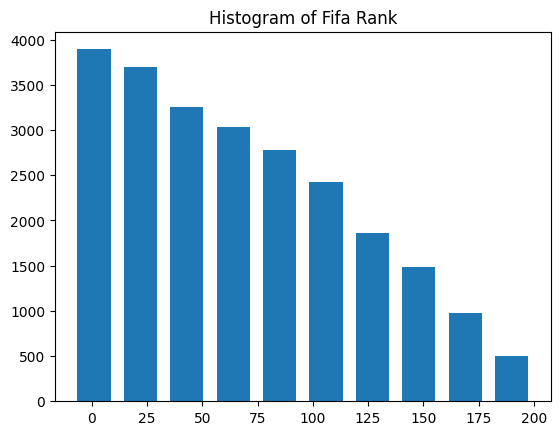

In [ ]:
## Lets do a HIST PLOT for home_team_rank
## As we already know from describe (min and max) the rank is from 1 to 211
## Now trying to understand how their dist looks like

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

hists = data.select('home_team_fifa_rank').rdd.flatMap(lambda row: row).histogram(10) # bin size
data_dict = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}
plt.bar(data_dict['bins'], data_dict['freq'], width=15)
plt.title('Histogram of Fifa Rank')
plt.show();

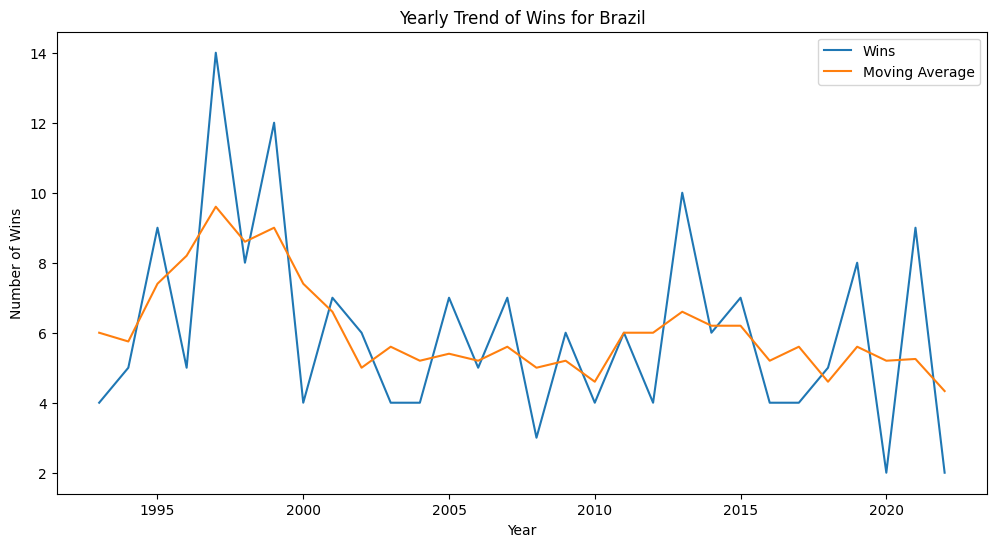

In [ ]:
# Lets get an annual trend of wins for Brazil with a moving average line

import matplotlib.pyplot as plt
# Convert 'date' column to datetime and extract year
data = data.withColumn("year", F.year(F.to_date("date")))

# Filter for Brazil and wins
brazil_wins = data.filter((F.col("home_team") == "Brazil") & (F.col("home_team_result") == "Win")) \
                  .groupBy("year") \
                  .count()

# Calculate moving average
window_spec = Window.orderBy("year").rowsBetween(-2, 2)  # Adjust window size as needed
brazil_wins = brazil_wins.withColumn("moving_avg", F.avg("count").over(window_spec))

# Convert to Pandas DataFrame for plotting
brazil_wins_pd = brazil_wins.toPandas()

# Plot the trend
plt.figure(figsize=(12, 6))
sns.lineplot(x="year", y="count", data=brazil_wins_pd, label="Wins")
sns.lineplot(x="year", y="moving_avg", data=brazil_wins_pd, label="Moving Average")
plt.title("Yearly Trend of Wins for Brazil")
plt.xlabel("Year")
plt.ylabel("Number of Wins")
plt.legend()
plt.show()


In [ ]:
## We dont have data going back to Pele Era, but the 90s is the prime time for Brazil when Ronaldinho, Ronaldo, Roberto Carlos were some stars

##### Instead of one country, how about we get the average wins for the top ranked country of each continent and compare the trend. We had a query before to calculate ranking by continent, we can leverage that and count wins for each of those top countries and do moving average.

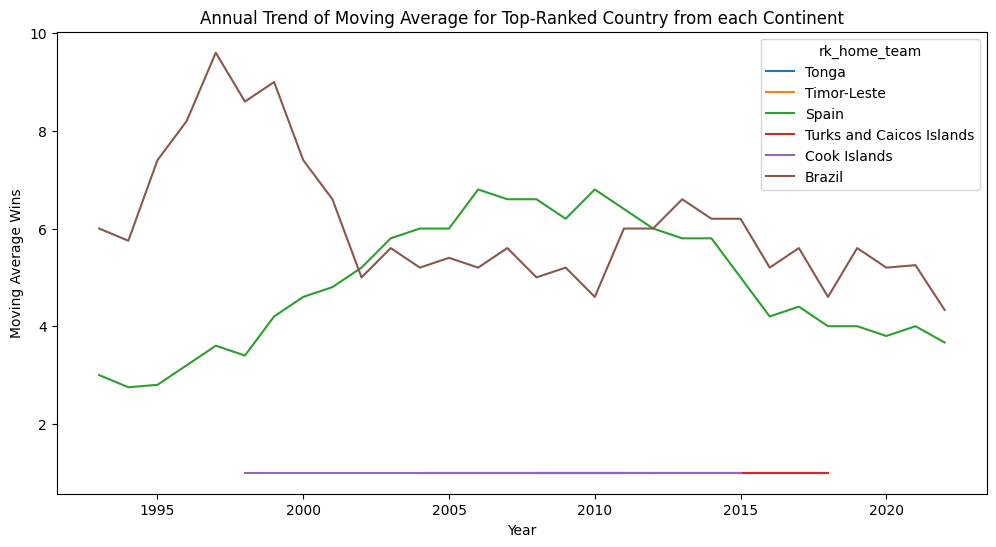

In [ ]:
# Create a window specification to partition by continent and order by total rank
window_spec = Window.partitionBy("home_team_continent").orderBy("total_rank")

# Calculate the rank for each team within their continent
ranked_df = data.groupBy(['home_team','home_team_continent']) \
    .agg(F.sum('home_team_fifa_rank').alias('total_rank')) \
    .withColumn("rank", row_number().over(window_spec)) \
    .filter(F.col("rank") == 1) \
    .select("home_team_continent", "home_team")

## Rename column home_team_continent to avoid ambiguity
ranked_df = ranked_df.withColumnRenamed("home_team_continent", "rk_home_team_continent")
ranked_df = ranked_df.withColumnRenamed("home_team", "rk_home_team")

# Join with original data to get the year and wins
top_ranked_data = data.join(ranked_df, data["home_team"] == ranked_df["rk_home_team"], "inner") \
    .withColumn("year", F.year(F.to_date("date"))) \
    .filter(F.col("home_team_result") == "Win") \
    .groupBy("home_team_continent", "year", "rk_home_team") \
    .count()

# # Calculate moving average
window_spec = Window.partitionBy(top_ranked_data["home_team_continent"]).orderBy("year").rowsBetween(-2, 2)
top_ranked_data = top_ranked_data.withColumn("moving_avg", F.avg("count").over(window_spec))

# Convert to Pandas DataFrame for plotting
top_ranked_data_pd = top_ranked_data.toPandas()

# Plot the trend
plt.figure(figsize=(12, 6))
sns.lineplot(x="year", y="moving_avg", data=top_ranked_data_pd, hue= top_ranked_data_pd["rk_home_team"]
              )
plt.title("Annual Trend of Moving Average for Top-Ranked Country from each Continent")
plt.xlabel("Year")
plt.ylabel("Moving Average Wins")
plt.show()


In [ ]:
## we can clearly see how Europe and South America Dominates the soccer world

#### Chapter 5: Feature Engineering

Feature engineering is the process of creating new input features or modifying existing ones to improve the performance of machine learning models. It involves transforming raw data into a format that is more suitable for model training by emphasizing relevant patterns and removing noise. This step is crucial in enhancing the predictive power of a model, especially when dealing with real-world data.

Key steps in feature engineering include:

- Handling Missing Data: Imputing or removing missing values.
- Scaling and Normalization: Ensuring numerical features have comparable scales, often by using techniques like min-max scaling or standardization.
- Encoding Categorical Variables: Converting categories into numerical values using techniques like one-hot encoding or label encoding.
- Creating New Features: Generating new features from existing ones, such as aggregating time-series data or calculating ratios.

###### We already saw missing values handling before, for now we will skip that part. We will focus on using scaling for one of the numerical column

In [ ]:
## lets recall our dataframe once

data.show(5)

+----------+---------+------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+--------------------+--------+--------+----------------+---------+----------------+------------+----+
|      date|home_team|   away_team|home_team_continent|away_team_continent|home_team_fifa_rank|away_team_fifa_rank|home_team_total_fifa_points|away_team_total_fifa_points|home_team_score|away_team_score|          tournament|    city| country|neutral_location|shoot_out|home_team_result|Result_Class|year|
+----------+---------+------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+--------------------+--------+--------+----------------+---------+----------------+------------+----+
|1993-08-08|  Bolivia|     Uruguay|      South America|      South America|          

In [ ]:
# descriptive stats for numerical columns and do a transpose to display

description = data.select(num_columns.tolist()).describe().toPandas().T
description


,0,1,2,3,4
summary,count,mean,stddev,min,max
home_team_fifa_rank,23921,77.85468834914928,52.35522517098862,1,211
away_team_fifa_rank,23921,80.79737469169349,53.2329018803766,1,211
home_team_total_fifa_points,23921,323.40148823209734,500.82572453797627,0,2164
away_team_total_fifa_points,23921,315.4535763555035,490.94427310371316,0,2164
home_team_score,23921,1.6092136616362192,1.63012671231451,0,31
away_team_score,23921,1.0682663768237113,1.263944312867616,0,21
Result_Class,23921,1.2086033192592283,0.8551210439874892,0,2


In [ ]:
## if you remember Result_Class is the numerical mapping we created for lose, draw and win.
## that means it is a categorical feature , not exactly numerical
print(mapping)

{'Lose': 0, 'Draw': 1, 'Win': 2}


In [ ]:
## for our example of doing scaling we will pick home team  points

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler

# Create a VectorAssembler to convert the 'home_team_total_fifa_points' column to a Vector
assembler = VectorAssembler(inputCols=["home_team_total_fifa_points"], outputCol="home_team_total_fifa_points_vec")

# Transform the data
data = assembler.transform(data)

# Define scaler
scaler = MinMaxScaler(inputCol="home_team_total_fifa_points_vec", outputCol="scaled_home_team_total_fifa_points")

# Fit scaler on data
scaler_model = scaler.fit(data)

# Transform data
scaled_df = scaler_model.transform(data)

# Select relevant columns
scaled_df = scaled_df.select("home_team_total_fifa_points", "scaled_home_team_total_fifa_points")

# Show scaled data
scaled_df.show()


+---------------------------+----------------------------------+
|home_team_total_fifa_points|scaled_home_team_total_fifa_points|
+---------------------------+----------------------------------+
|                          0|                             [0.0]|
|                          0|                             [0.0]|
|                          0|                             [0.0]|
|                          0|                             [0.0]|
|                          0|                             [0.0]|
|                          0|                             [0.0]|
|                          0|                             [0.0]|
|                          0|                             [0.0]|
|                          0|                             [0.0]|
|                          0|                             [0.0]|
|                          0|                             [0.0]|
|                          0|                             [0.0]|
|                        

In [ ]:
# Most of he home team points seem zero but lets filter scaled_df show where home_team_total_fifa_points are not 0
scaled_df.filter(scaled_df['home_team_total_fifa_points'] != 0).show()


+---------------------------+----------------------------------+
|home_team_total_fifa_points|scaled_home_team_total_fifa_points|
+---------------------------+----------------------------------+
|                        260|              [0.12014787430683...|
|                        245|              [0.11321626617375...|
|                        298|              [0.1377079482439926]|
|                        325|              [0.15018484288354...|
|                        338|              [0.15619223659889...|
|                        179|              [0.08271719038817...|
|                        348|              [0.16081330868761...|
|                        104|              [0.04805914972273...|
|                        311|              [0.14371534195933...|
|                         78|              [0.03604436229205...|
|                        307|              [0.14186691312384...|
|                        104|              [0.04805914972273...|
|                        

##### Now we saw how scaling of features work, next thing in our Feature Engineering is to look at how to encode categorical features

In [ ]:

## lets first print all our categorical features

print(cat_columns)

['home_team', 'away_team', 'home_team_continent', 'away_team_continent', 'tournament', 'city', 'country', 'neutral_location', 'shoot_out', 'home_team_result']


In [ ]:
## For example purpose we can pick one hot encode of home_team_continent

from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Create a StringIndexer to convert the 'home_team_continent' column to numerical indices
indexer = StringIndexer(inputCol="home_team_continent", outputCol="home_team_continent_index")
data = indexer.fit(data).transform(data)

# Create a OneHotEncoder to convert the indexed column to a one-hot encoded vector
encoder = OneHotEncoder(inputCols=["home_team_continent_index"], outputCols=["home_team_continent_encoded"])
data = encoder.fit(data).transform(data)

# Show the data with the encoded column
data.select("home_team_continent", "home_team_continent_encoded").show(5)


+-------------------+---------------------------+
|home_team_continent|home_team_continent_encoded|
+-------------------+---------------------------+
|      South America|              (5,[4],[1.0])|
|      South America|              (5,[4],[1.0])|
|      South America|              (5,[4],[1.0])|
|             Africa|              (5,[1],[1.0])|
|      South America|              (5,[4],[1.0])|
+-------------------+---------------------------+
only showing top 5 rows



##### Now the fun part of feature engineering: Creating additional features or derived features based on existing columns

1. Difference in FIFA Rankings
- Rank difference: Calculate the difference between home_team_fifa_rank and away_team_fifa_rank. This can give insight into the relative strength of the teams.

In [ ]:
from pyspark.sql.functions import col
data = data.withColumn("fifa_rank_diff", col("home_team_fifa_rank") - col("away_team_fifa_rank"))
data.select("home_team_fifa_rank", "away_team_fifa_rank", "fifa_rank_diff").show(5)


+-------------------+-------------------+--------------+
|home_team_fifa_rank|away_team_fifa_rank|fifa_rank_diff|
+-------------------+-------------------+--------------+
|                 59|                 22|            37|
|                  8|                 14|            -6|
|                 35|                 94|           -59|
|                 65|                 86|           -21|
|                 67|                  5|            62|
+-------------------+-------------------+--------------+
only showing top 5 rows



2. Performance Indicators
- Goal difference: Compute the goal difference between the home and away team, which is an important indicator of team performance.

In [ ]:
data = data.withColumn("goal_diff", col("home_team_score") - col("away_team_score"))
data.select("home_team_score", "away_team_score", "goal_diff").show(5)

+---------------+---------------+---------+
|home_team_score|away_team_score|goal_diff|
+---------------+---------------+---------+
|              3|              1|        2|
|              1|              1|        0|
|              5|              0|        5|
|              1|              0|        1|
|              1|              3|       -2|
+---------------+---------------+---------+
only showing top 5 rows



3. Tournament Importance
- Tournament Type: Create a categorical feature based on the tournament type, as some tournaments (World Cup, regional cups) are more prestigious and competitive than friendlies.

In [ ]:
# print all the distinct values in tournament in sorted order

data.select('tournament').distinct().orderBy('tournament').show(data.count())


+--------------------+
|          tournament|
+--------------------+
|     ABCS Tournament|
|       AFC Asian Cup|
|AFC Asian Cup qua...|
|   AFC Challenge Cup|
|AFC Challenge Cup...|
|    AFF Championship|
|AFF Championship ...|
|African Cup of Na...|
|African Cup of Na...|
|African Nations C...|
|African Nations C...|
|    Afro-Asian Games|
|  Amílcar Cabral Cup|
|            Arab Cup|
|Arab Cup qualific...|
|          Baltic Cup|
|          CECAFA Cup|
|   CFU Caribbean Cup|
|CFU Caribbean Cup...|
|CONCACAF Nations ...|
|CONCACAF Nations ...|
|CONMEBOL–UEFA Cup...|
|          COSAFA Cup|
|COSAFA Cup qualif...|
|  Confederations Cup|
|        Copa América|
|Copa América qual...|
| Copa Confraternidad|
|  Copa Paz del Chaco|
|   Copa del Pacífico|
|Cup of Ancient Ci...|
|Cyprus Internatio...|
|          Dragon Cup|
|         Dunhill Cup|
|         Dynasty Cup|
|   EAFF Championship|
|      FIFA World Cup|
|FIFA World Cup qu...|
|            Friendly|
|            Gold Cup|
|Gold Cup q

In [ ]:
## Two of the major competitions are Fifa World Cup and European Cup
from pyspark.sql.functions import when
data = data.withColumn("tournament_type", when(col("tournament").isin("FIFA World Cup", "UEFA Euro"), "Major").otherwise("Other"))
data.select("tournament", "tournament_type").show(20)

+--------------------+---------------+
|          tournament|tournament_type|
+--------------------+---------------+
|FIFA World Cup qu...|          Other|
|            Friendly|          Other|
|FIFA World Cup qu...|          Other|
|            Friendly|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|            Friendly|          Other|
|            Friendly|          Other|
|            Friendly|          Other|
|            Friendly|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|African Cup of Na...|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
+--------------------+---------------+
only showing top 20 rows



In [ ]:
# if tournament has 'Friendly' add tournament_type as 'Friendly'

data = data.withColumn("tournament_type",
                        when(col("tournament").contains("Friendly"), "Friendly")
                        .otherwise(col("tournament_type")))
data.select("tournament", "tournament_type").show(20)

+--------------------+---------------+
|          tournament|tournament_type|
+--------------------+---------------+
|FIFA World Cup qu...|          Other|
|            Friendly|       Friendly|
|FIFA World Cup qu...|          Other|
|            Friendly|       Friendly|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|            Friendly|       Friendly|
|            Friendly|       Friendly|
|            Friendly|       Friendly|
|            Friendly|       Friendly|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|African Cup of Na...|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
|FIFA World Cup qu...|          Other|
+--------------------+---------------+
only showing top 20 rows



In [ ]:
# sample some data, scroll right to see new features created

data.sample(fraction=0.01).show()


+----------+---------------+------------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+--------------------+--------------+---------------+----------------+---------+----------------+------------+----+-------------------------------+-------------------------+---------------------------+--------------+---------+---------------+
|      date|      home_team|         away_team|home_team_continent|away_team_continent|home_team_fifa_rank|away_team_fifa_rank|home_team_total_fifa_points|away_team_total_fifa_points|home_team_score|away_team_score|          tournament|          city|        country|neutral_location|shoot_out|home_team_result|Result_Class|year|home_team_total_fifa_points_vec|home_team_continent_index|home_team_continent_encoded|fifa_rank_diff|goal_diff|tournament_type|
+----------+---------------+------------------+-------------------+-------------------

#### Lets Visualize the distribution of tournament type feature we created

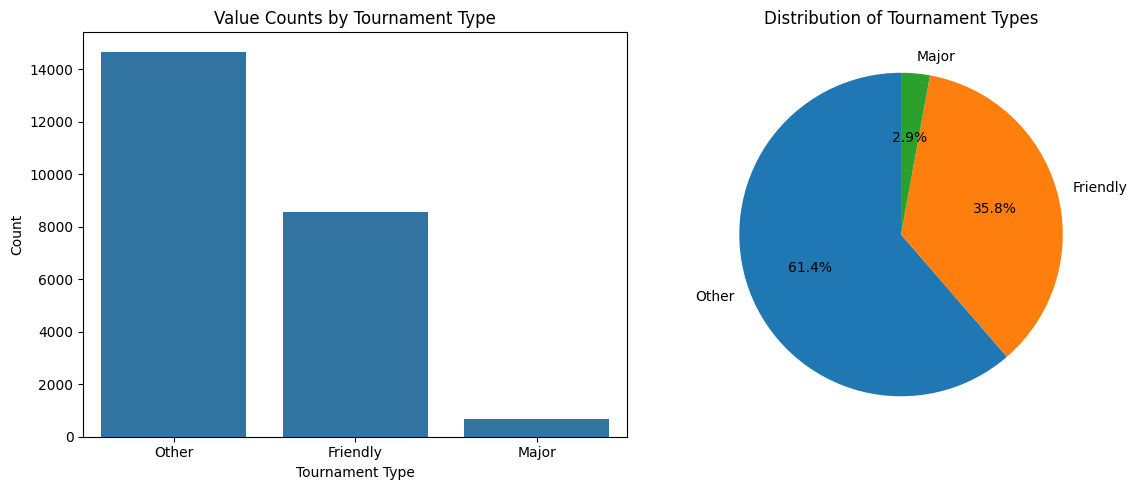

In [ ]:
import matplotlib.pyplot as plt
# Calculate value counts for tournament_type
tournament_type_counts = data.groupBy("tournament_type").count().toPandas()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
sns.barplot(x="tournament_type", y="count", data=tournament_type_counts, ax=axes[0])
axes[0].set_title("Value Counts by Tournament Type")
axes[0].set_xlabel("Tournament Type")
axes[0].set_ylabel("Count")

# Pie chart
axes[1].pie(tournament_type_counts["count"], labels=tournament_type_counts["tournament_type"], autopct='%1.1f%%', startangle=90)
axes[1].set_title("Distribution of Tournament Types")

plt.tight_layout()
plt.show()


### Chapter 6: Model Building

We will spend some time on model building now. Before that we will make sure the feature set is ready.

In [ ]:
data.show(5)

+----------+---------+------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+--------------------+--------+--------+----------------+---------+----------------+------------+----+-------------------------------+-------------------------+---------------------------+--------------+---------+---------------+
|      date|home_team|   away_team|home_team_continent|away_team_continent|home_team_fifa_rank|away_team_fifa_rank|home_team_total_fifa_points|away_team_total_fifa_points|home_team_score|away_team_score|          tournament|    city| country|neutral_location|shoot_out|home_team_result|Result_Class|year|home_team_total_fifa_points_vec|home_team_continent_index|home_team_continent_encoded|fifa_rank_diff|goal_diff|tournament_type|
+----------+---------+------------+-------------------+-------------------+-------------------+-------------------+---------------------

In [ ]:
#  print min and max date from data

from pyspark.sql.functions import min, max

min_date = data.select(min("date")).first()[0]
max_date = data.select(max("date")).first()[0]

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")


Minimum date: 1993-08-08
Maximum date: 2022-06-14


##### Something interesting to notice in time series data, that there is a concept of data drifting, meaning things change over time. It is one important QUESTION in data science: How far back we can go in the historical data to capture the meaningful context. In our case it could be that:

- Many players have retired
- Rules have changed
- New players come into team
- Players aged
- Other factors

In [ ]:
# filter data from last twenty years: since major tournaments like worldcup happens once every four years

from pyspark.sql.functions import current_date, datediff

# Calculate the date ten years ago
twenty_years_ago = current_date() - F.expr("INTERVAL 20 years")

# Filter the data to include only the last ten years
filtered_data = data.filter(F.col("date") >= twenty_years_ago)

filtered_data.show(5)


+----------+--------------------+-----------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+----------+---------------+--------------------+----------------+---------+----------------+------------+----+-------------------------------+-------------------------+---------------------------+--------------+---------+---------------+
|      date|           home_team|        away_team|home_team_continent|away_team_continent|home_team_fifa_rank|away_team_fifa_rank|home_team_total_fifa_points|away_team_total_fifa_points|home_team_score|away_team_score|tournament|           city|             country|neutral_location|shoot_out|home_team_result|Result_Class|year|home_team_total_fifa_points_vec|home_team_continent_index|home_team_continent_encoded|fifa_rank_diff|goal_diff|tournament_type|
+----------+--------------------+-----------------+-------------------+---------------

In [ ]:
# check how much data pointt we lost compare size of data and filtered_data

original_data_count = data.count()
filtered_data_count = filtered_data.count()

data_lost = original_data_count - filtered_data_count

print(f"Original data count: {original_data_count}")
print(f"Filtered data count: {filtered_data_count}")
print(f"Data lost: {data_lost}")
print(f"Percentage of data lost: {(data_lost / original_data_count) * 100:.2f}%")


Original data count: 23921
Filtered data count: 15567
Data lost: 8354
Percentage of data lost: 34.92%


In [ ]:
# list the unique names in home_team everything without truncate sorting by name

data.select('home_team').distinct().orderBy('home_team').show(data.count(), truncate=False)


+------------------------------+
|home_team                     |
+------------------------------+
|Afghanistan                   |
|Albania                       |
|Algeria                       |
|American Samoa                |
|Andorra                       |
|Angola                        |
|Anguilla                      |
|Antigua and Barbuda           |
|Argentina                     |
|Armenia                       |
|Aruba                         |
|Australia                     |
|Austria                       |
|Azerbaijan                    |
|Bahamas                       |
|Bahrain                       |
|Bangladesh                    |
|Barbados                      |
|Belarus                       |
|Belgium                       |
|Belize                        |
|Benin                         |
|Bermuda                       |
|Bhutan                        |
|Bolivia                       |
|Bosnia and Herzegovina        |
|Botswana                      |
|Brazil   

In [ ]:
## Lets clean up our features now: for learning purpose we added everything

selected_columns = ['date', 'home_team', 'away_team', 'home_team_continent',
       'away_team_continent', 'home_team_fifa_rank', 'away_team_fifa_rank',
       'home_team_total_fifa_points', 'away_team_total_fifa_points',
       'home_team_score', 'away_team_score', 'city', 'country',
       'neutral_location', 'shoot_out',
       'fifa_rank_diff', 'goal_diff','tournament_type', 'Result_Class']

filtered_data = filtered_data.select(selected_columns)
filtered_data.show(5)

+----------+--------------------+-----------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+---------------+--------------------+----------------+---------+--------------+---------+---------------+------------+
|      date|           home_team|        away_team|home_team_continent|away_team_continent|home_team_fifa_rank|away_team_fifa_rank|home_team_total_fifa_points|away_team_total_fifa_points|home_team_score|away_team_score|           city|             country|neutral_location|shoot_out|fifa_rank_diff|goal_diff|tournament_type|Result_Class|
+----------+--------------------+-----------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------------+---------------+---------------+---------------+--------------------+----------------+---------+--------------+---------+---------------+

#### Lets Build our first ML model

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler

## changing shoot_out from boolean to int encode
filtered_data = filtered_data.withColumn("shoot_out", when(col("shoot_out") == "Yes", 1).otherwise(0))

# Split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = filtered_data.randomSplit([0.8, 0.2], seed=42)

# Convert categorical features to numerical using StringIndexer
categorical_cols = ['home_team', 'away_team', 'home_team_continent', 'away_team_continent', 'city', 'country', 'tournament_type']
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index").fit(filtered_data) for col in categorical_cols]

for indexer in indexers:
  train_data = indexer.transform(train_data)
  test_data = indexer.transform(test_data)

# Assemble features into a vector
feature_cols = ['home_team_fifa_rank', 'away_team_fifa_rank',
                'home_team_total_fifa_points', 'away_team_total_fifa_points',
                'home_team_score', 'away_team_score',
                'neutral_location', 'shoot_out', 'fifa_rank_diff', 'goal_diff'] + [col + "_index" for col in categorical_cols]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Separate features and label
train_data = train_data.select("features", "Result_Class")
test_data = test_data.select("features", "Result_Class")



# Build a Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="Result_Class")
model = lr.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Result_Class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", round(accuracy,2))

Accuracy: 0.99


In [ ]:
import warnings
warnings.filterwarnings("ignore")

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col

# Make predictions on the test data
predictions = model.transform(test_data)

# Select prediction and true label columns and cast to double
predictionAndLabels = predictions.select(col("prediction").cast("double"), col("Result_Class").cast("double")).rdd

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Generate confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

print("Confusion Matrix:")
print("----------------------")
print(np.round(confusion_matrix).astype(int))

Confusion Matrix:
----------------------
[[ 877   15    0]
 [   0  705    0]
 [   1   17 1440]]


In [ ]:
# Lets calculate Precision Recall and change to our original label  {'Lose': 0, 'Draw': 1, 'Win': 2}

import numpy as np
# Assuming 'confusion_matrix' is the confusion matrix you obtained
# and the mapping is {'Lose': 0, 'Draw': 1, 'Win': 2}

# Calculate precision and recall for each class
labels = ['Lose', 'Draw', 'Win']
for i in range(3):
    tp = confusion_matrix[i][i]
    fp = np.sum(confusion_matrix[:, i]) - tp
    fn = np.sum(confusion_matrix[i, :]) - tp
    tn = np.sum(confusion_matrix) - tp - fp - fn

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    print(f"Class: {labels[i]}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("-" * 20)

Class: Lose
Precision: 0.9889
Recall: 0.9944
--------------------
Class: Draw
Precision: 1.0000
Recall: 1.0000
--------------------
Class: Win
Precision: 0.9966
Recall: 0.9931
--------------------


### STAY TUNED !!! MORE CHAPTERS ARE COMING

#### Chapter 7: More Models to Try and Evaluate